In [4]:
!pip install datasets evaluate torch

### Name: Hassan Fakih Osman
### ID: 121200078
### CMPE 346 Assigment 2
### Binary Sentiment Classifier

### In this assignment, I used google's bert-base-uncased, I used such model because first it is uncased as in it doesn't differentiate between 'English' or 'english' with no capital letters. Also, such model is primarily aimed at being fine-tuned on tasks that use the whole sentence to make decisions, which fits our aim because we have to look entirely at the sentence to decide whether it is positive sentiment or negative sentiment. The model also has a wide vocabulary as it has been pretrained on BookCorpus and English Wikipedia. Finally, I went for this model because it seems to be quite popular so I'd like to test here in this assignment to see how it works.

#### Model URL: https://huggingface.co/google-bert/bert-base-uncased

#### Also, note that this notebook was ran on a GPU, because running on a CPU is quite slow and not as good as a GPU for parallel tasks.




In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer, BertForSequenceClassification
import torch

# Define the device to be used
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the datasets
tweet_dataset = load_dataset("mteb/tweet_sentiment_extraction").shuffle(seed=42)
imdb_dataset = load_dataset("stanfordnlp/imdb").shuffle(seed=42)

# Use the model's tokenizer
checkpoint = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Define the model to be used
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Visualize the dataset

In [6]:
tweet_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [7]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
# You can run this to narrow down the number of samples if training is too long

# tweet_dataset['train'] = tweet_dataset['train'].select(range(10000))
# imdb_dataset['train'] = imdb_dataset['train'].select(range(10000))
# imdb_dataset['test'] = imdb_dataset['test'].select(range(10000))

In [9]:
tweet_dataset['train'].to_pandas().head()

,id,text,label,label_text
0,fd8e3ede29,what happen to the maids of yours? Quit once ...,1,neutral
1,9206b5221d,Listening to the commentary track on Holiday I...,2,positive
2,d6b51b539f,"chatting with some of my old classmates, helly...",1,neutral
3,5bd1a6d051,OOuUch!...good luck,2,positive
4,e7948d93b8,I think my iPod touch may be breaking itself.,1,neutral


In [10]:
imdb_dataset['train'].to_pandas().head()

,text,label
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0


### Preprocessing

The tweet dataset contains 3 unique labels: negative, neutral, and positive. The instances with neutral labels will be removed.

0 --> negative<br>
1 --> neutral<br>
2 --> postive

meaning we have to remove instances with label 1.


In [11]:
# Get unique labels
tweet_labels_train = set(tweet_dataset['train']['label'])
tweet_labels_test = set(tweet_dataset['test']['label'])

print(f"[Tweet Train] Unique labels: {tweet_labels_train}")
print(f"[Tweet Test] Unique labels: {tweet_labels_test}")

[Tweet Train] Unique labels: {0, 1, 2}
[Tweet Test] Unique labels: {0, 1, 2}


In [12]:
# Removing instances with label 1 (neutral) in the tweet dataset

tweet_dataset['train'] = tweet_dataset['train'].filter(lambda x: x['label'] != 1)
tweet_dataset['test'] = tweet_dataset['test'].filter(lambda x: x['label'] != 1)

However, now we have to change the labels of value 2 which means postive to 1 in the tweet dataset, so to match with the imdb dataset which would have label 1 for postives.

In [13]:
# Get unique labels
tweet_labels_train = set(tweet_dataset['train']['label'])
tweet_labels_test = set(tweet_dataset['test']['label'])

print(f"[Tweet Train] Unique labels: {tweet_labels_train}")
print(f"[Tweet Test] Unique labels: {tweet_labels_test}")

[Tweet Train] Unique labels: {0, 2}
[Tweet Test] Unique labels: {0, 2}


In [14]:
# Change instances with label 2 to 1

tweet_dataset['train'] = tweet_dataset['train'].map(lambda x: {'label': 1 if x['label'] == 2 else x['label']})
tweet_dataset['test'] = tweet_dataset['test'].map(lambda x: {'label': 1 if x['label'] == 2 else x['label']})

In [15]:
# Get unique labels
tweet_labels_train = set(tweet_dataset['train']['label'])
tweet_labels_test = set(tweet_dataset['test']['label'])

print(f"[Tweet Train] Unique labels: {tweet_labels_train}")
print(f"[Tweet Test] Unique labels: {tweet_labels_test}")

[Tweet Train] Unique labels: {0, 1}
[Tweet Test] Unique labels: {0, 1}


### Remove columns 'id' and 'label_text' from the tweet dataset because they wont be used, plus so that the training set of the tweet dataset could match with the training set of the imdb dataset

In [16]:
tweet_dataset = tweet_dataset.remove_columns(['id', 'label_text'])

In [17]:
tweet_dataset['train'].to_pandas().head()

,text,label
0,Listening to the commentary track on Holiday I...,1
1,OOuUch!...good luck,1
2,But then you might end up like that poor bus ...,0
3,haha its awesome i always have to use it when...,1
4,AWOOOOGAHHHHHH!!!! heheee hope you get some ...,1


## The tweet dataset carries two features, the text of type 'Value' and label of type 'Value', the imdb dataset also has the same features but its label is of type 'ClassLabel' so we change the type of label in tweet dataset to that, so that they could both match and let us concatenate them.

In [18]:
tweet_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [19]:
imdb_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [20]:
from datasets import Dataset, Value, ClassLabel, Features

# Adjusting the features of tweet training set
tweet_train_df = tweet_dataset['train'].to_pandas() # Change the dataset to pandas dataframe

features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'])}) # Specify the types of features
tweet_dataset['train'] = Dataset.from_pandas(tweet_train_df, features=features) # Change the dataframe back to a huggingface dataset along with the new feauture types

tweet_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [21]:
# Adjusting the features of tweet testing set
tweet_test_df = tweet_dataset['test'].to_pandas() # Change the dataset to pandas dataframe

features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=2, names=['neg', 'pos'])}) # Specify the types of features
tweet_dataset['test'] = Dataset.from_pandas(tweet_test_df, features=features) # Change the dataframe back to a huggingface dataset along with the new feauture types

tweet_dataset['test'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [22]:
from datasets import concatenate_datasets

# Finally merge the training sets
train_dataset = concatenate_datasets([imdb_dataset['train'], tweet_dataset['train']])

In [23]:
# Result
train_dataset.to_pandas()

,text,label
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0
...,...,...
41358,Slipped up and caught the flu feeling like poop!,0
41359,No it`s not sad. Should make you proud,0
41360,Whew. Finally done editing my Friendster accou...,0
41361,Test discovery just missed being in Py3.1,0


### Finally, we merge everything into one Dataset Dictionary

In [24]:
from datasets import DatasetDict

train_split = train_dataset.train_test_split(test_size=0.1) # Split the training set into two, 90% training and 10% Validation

dataset = DatasetDict({
    "train": train_split['train'],
    'valid': train_split['test'],
    "tweet_test": tweet_dataset['test'],
    "imdb_test": imdb_dataset['test']
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 37226
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 4137
    })
    tweet_test: Dataset({
        features: ['text', 'label'],
        num_rows: 2104
    })
    imdb_test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

### Tokenize the texts in the dataset

In [25]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
  return tokenizer(example['text'], truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/37226 [00:00<?, ? examples/s]

Map:   0%|          | 0/4137 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

### Drop the text column after tokenizing, because we have no use for it anymore, we now have the tokenized version. And change the format of the dataset to torch

In [26]:
tokenized_dataset = tokenized_dataset.remove_columns(['text'])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

tokenized_dataset.set_format('torch')

In [27]:
tokenized_dataset['train'].features

{'labels': ClassLabel(names=['neg', 'pos'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [28]:
from torch.utils.data import DataLoader

# The batch size is good enough, however it can be increased to further make the training faster but it would use more RAM.
BATCH_SIZE = 16

train_dataloader = DataLoader(
    tokenized_dataset['train'], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator
)

valid_dataloader = DataLoader(
    tokenized_dataset['valid'], shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator
)

# The test sets are kept seperate
tweet_test_dataloader = DataLoader(
    tokenized_dataset['tweet_test'], batch_size=BATCH_SIZE, collate_fn=data_collator
)

imdb_test_dataloader = DataLoader(
    tokenized_dataset['imdb_test'], batch_size=BATCH_SIZE, collate_fn=data_collator
)

In [29]:
for batch in train_dataloader:
  break
{k: v for k, v in batch.items()}

{'labels': tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1]),
 'input_ids': tensor([[ 101, 2009, 1036,  ...,    0,    0,    0],
         [ 101, 1042, 1008,  ...,    0,    0,    0],
         [ 101, 1045, 2031,  ...,    0,    0,    0],
         ...,
         [ 101, 2307, 2265,  ...,    0,    0,    0],
         [ 101, 3243, 2035,  ...,    0,    0,    0],
         [ 101, 2065, 2017,  ...,    0,    0,    0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

## Training

### I used the same optimizer and scheduler that google used for pretraining their bert model (Maybe not exactly the same) I thought it would make sense to do that.

In [31]:
from tqdm.auto import tqdm
from transformers import get_scheduler

# Hyperparameters
EPOCHS = 3 # If we are to increase epochs we could have lower loss, but for now 3 is set because I don't want training to be long
LEARNING_RATE = 5e-5  # Typically, a smaller learning rate is used

# Total number of training steps
num_of_training_steps = EPOCHS * len(train_dataloader)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * EPOCHS,
)

progress_bar = tqdm(range(num_of_training_steps))
train_losses = []

# Training
model.train() # Switch to training mode
for epoch in range(EPOCHS):
    epoch_losses = []
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss

        # Record the losses in each epoch and after each training step
        epoch_losses.append(loss.item())
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step() # Step the optimizer
        scheduler.step() # Step the learning rate

        progress_bar.update(1)

    # Print the average loss for this epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Average Loss: {avg_loss}")

progress_bar.close()

  0%|          | 0/6981 [00:00<?, ?it/s]

Epoch 1/3, Average Loss: 0.2405421478508923
Epoch 2/3, Average Loss: 0.11585929432772196
Epoch 3/3, Average Loss: 0.03951711780174512


In [32]:
import evaluate

# Validation

metric_acc = evaluate.load('accuracy')
val_losses = []

model.eval() # Switch to evalutation mode
for batch in valid_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}

  with torch.no_grad():
    outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])

  val_losses.append(outputs.loss.item())
  logits = outputs.logits
  _, predictions = torch.max(logits, dim=1)
  metric_acc.add_batch(predictions=predictions, references=batch['labels'])

print(metric_acc.compute())

{'accuracy': 0.9286922890983804}


## Plotting the losses (In each training step)
### We can see overall how the losses start to decrease after each training step

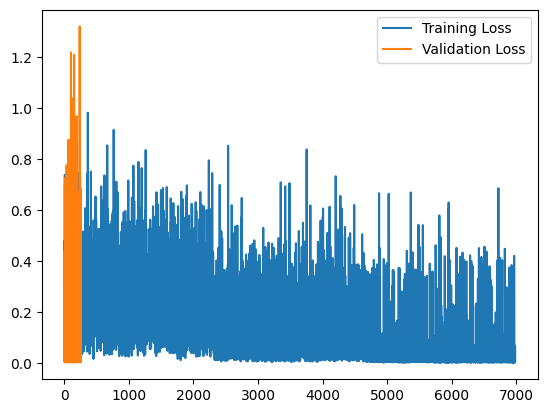

In [33]:
import matplotlib.pyplot as plt

# train_losses & val_losses plot

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

## Testing and Evaluation
### We first apply testing on the tweet test set, then the imdb test set. Report the accuracies
### And then finally come up with our own examples to see how our model performs to that

In [34]:
metric_acc = evaluate.load('accuracy')

# Testing using the tweet test dataset

model.eval()
for batch in tweet_test_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}

  with torch.no_grad():
    outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])

  logits = outputs.logits
  _, predictions = torch.max(logits, dim=1)
  metric_acc.add_batch(predictions=predictions, references=batch['labels'])

print(metric_acc.compute())

{'accuracy': 0.9462927756653993}


In [35]:
metric_acc = evaluate.load('accuracy')

# Testing using the imdb test dataset

model.eval()
for batch in imdb_test_dataloader:
  batch = {k: v.to(device) for k, v in batch.items()}

  with torch.no_grad():
    outputs = model(batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])

  logits = outputs.logits
  _, predictions = torch.max(logits, dim=1)
  metric_acc.add_batch(predictions=predictions, references=batch['labels'])

print(metric_acc.compute())

{'accuracy': 0.93464}


In [36]:
# Again, 0 is negative, and 1 is positive

examples = [
    "The movie is terrible, i hate it, it's the worse, biggest mistake of my life", # 0
    "This movie is terrible. NOT RECOMMENDED!", # 0
    "The movie was honestly the best thing i ever watched", # 1
    "The movie exceeded my expectations", # 1
    "The plot was very well written", # 1
    "I am not a fan of the director, he always manages to make it bad", # 0
    "I really liked it, totally recommend others to see", # 1
    "I wasn't a fan of the plot, but i think the fight scenes were great", # ? (Checking how it'd react to neutral)
    "The movie was very touching", # 1
    "Waste of money" # 0
]

tokenized_examples = tokenizer(examples, return_tensors='pt', truncation=True, padding=True).to(device)

with torch.no_grad():
  outputs = model(**tokenized_examples)

logits = outputs.logits
torch.argmax(logits, dim=-1) # Expected outcome: [0, 0, 1, 1, 1, 0, 1, ?, 1, 0]

tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')